# Dirichlet process mixture models

[Bayesian mixture models](bayesian_mixture_models.ipynb) introduced how to infer the posterior of the parameters of a mixture model with a fixed number of components $K$. We can either find $K$ using model selection, i.e. with AIC, BIC, WAIC, etc., or try to automatically infer this number. Nonparametric mixture models do exactly this. 

Here we implement a nonparametric Bayesian mixture model using *Gibbs sampling*. We use a *Chinese restaurant process* prior and stick-breaking construction to sample from a *Dirichlet process* (see for instance Nils Hjort's [*Bayesian Nonparametrics*](https://www.cambridge.org/ch/academic/subjects/statistics-probability/statistical-theory-and-methods/bayesian-nonparametrics?format=HB&isbn=9780521513463), Peter Orbanz' [lecture notes](http://stat.columbia.edu/~porbanz/papers/porbanz_BNP_draft.pdf)), Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) and last but not least Herman Kamper's [notes](https://www.kamperh.com/notes/kamper_bayesgmm13.pdf). 

We'll implement the Gibbs sampler using the CRP ourselves, since (I think) Stan doesn't allow us to do this and then use the stick-breaking construction with Stan. That is technically not possible though, so we use a small hack.

**As usual I do not take warranty for the correctness or completeness of this document.**

In [Bayesian mixture models](bayesian_mixture_models.ipynb) we used following hierarchical form to describe a mixture model:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0\\
\boldsymbol \pi &  \sim \text{Dirichlet}(\boldsymbol \alpha_0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim {P}(\boldsymbol \theta_k)
\end{align*}

where $\mathcal{G}_0$ is some base distribution for the model parameters.

The DP on contrast, as any BNP model, puts priors on structures that accomodate infinite sizes. The resulting posteriors give a distribution on structures that grow with new observations. A mixture model using an possibly infinite number of components could look like this:

\begin{align*}
\mathcal{G} & \sim \mathcal{DP}(\alpha, \mathcal{G}_0)\\
\boldsymbol \theta_1, \boldsymbol \theta_2, \dots  & \sim \mathcal{G}\\
\mathbf{x}_i&  \sim {P}(\boldsymbol \theta_i)
\end{align*}

where $\mathcal{G}_0$ is the same base measure as above and $\mathcal{G}$ is a sample from the DP, i.e. also a random measure.

## The Chinese restaurant process

One way, and possibly the easiest, to implement a DPMM is using a *Chinese restaurant process* (CRP) which is a distribution over partitions. We will first discuss how a CRP creates the data and then build a Gibbs sampler to infer the parameters of a Gaussian DPMM.

### Data generating process

Assuming normally distributed data the hierarchical model for the mixture using a CRP is:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0 \\
z_i \mid \mathbf{z}_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim P(\boldsymbol \theta_{z_i})
\end{align*}

where $\text{CRP}$ is a prior on possible infinitely many classes. Specifically the CRP is defined as:

\begin{align*}
P(z_i = k \mid \mathbf{z}_{-i}) = \left\{
                \begin{array}{ll}
                  \frac{N_k}{N - 1 + \alpha}\\
                  \frac{\alpha}{N - 1 + \alpha}\\
                \end{array}
              \right.
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter.

For the variables of interest, $\boldsymbol  \theta_k$ and $\boldsymbol z$ the posterior is:

\begin{align*}
P(\boldsymbol \theta, \boldsymbol z \mid \mathbf{X}) \propto P(\mathbf{X} \mid \boldsymbol \theta, \boldsymbol z ) P(\boldsymbol \theta) P ( \boldsymbol z )
\end{align*}

In the Gaussian case the hierarchical model above has the following form:

\begin{align*}
\boldsymbol \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol \mu_k & \sim \mathcal{N}(\boldsymbol \mu_0, \boldsymbol \Sigma_0) \\
z_i \mid z_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim \mathcal{N}(\boldsymbol \mu_{z_i}, \boldsymbol \Sigma_{z_i})
\end{align*}

Using a Gibbs sampler, we iterate over the following three steps:

1) sample $z_i \sim P(z_i \mid \mathbf{z}_{-i}, \mathbf{X}, \boldsymbol \theta) \propto P(z_i \mid \mathbf{z}_{-i}) P(\mathbf{x}_i \mid \boldsymbol \theta_{z_i})$

2) sample $\boldsymbol \theta_k \sim P(\boldsymbol \theta_k \mid \mathbf{z}, \mathbf{X})$

So we alternate sampling assignments of data to classes and sampling the parameters of a normal distribution given the class assignments. The major difference here compared to the finite case is the way of sampling $z_i$ which we do using the CRP in the infinite case.

In [4]:
options(repr.fig.width=4, repr.plot.height=3)

In [3]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
set.seed(23)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

First we set data $\mathbf{X}$ some constants. We create a very simple data set to avoid problems with identifiability and label switching. For a treatment of the topic see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html).

In [5]:
n <- 100
p <- 2
alpha <- .5

Latent class assignments (`Z`), the current table index and the number of customers per table.

In [6]:
Z <- integer(n)
X <- matrix(0, n, p)
curr.tab <- 0
tables <- c()

In [7]:
sigma <- .1
mus <- NULL

Then we create a random assignment of customers to tables with probability $P(z_i \mid Z_{-i})$, i.e. we use the CRP to put data into classes.
Note that we don't know the number of classes that comes out!

In [8]:
for (i in seq(n))
{   
    probs <- c(tables / (i - 1 + alpha), alpha / (i - 1 + alpha))
    table <- rdiscrete(1, probs)
    if (table > curr.tab) 
    {
        curr.tab <- curr.tab + 1
        tables <- c(tables, 0)
        mu <- mvtnorm::rmvnorm(1, c(0, 0), 10 * diag(p))
        mus <- rbind(mus, mu)
    }
    Z[i] <- table
    X[i,] <- mvtnorm::rmvnorm(1, mus[Z[i], ], sigma * diag(p))
    tables[table] <-  tables[table] + 1
}

Let's see how many clusters and how many data points per clusters we have.

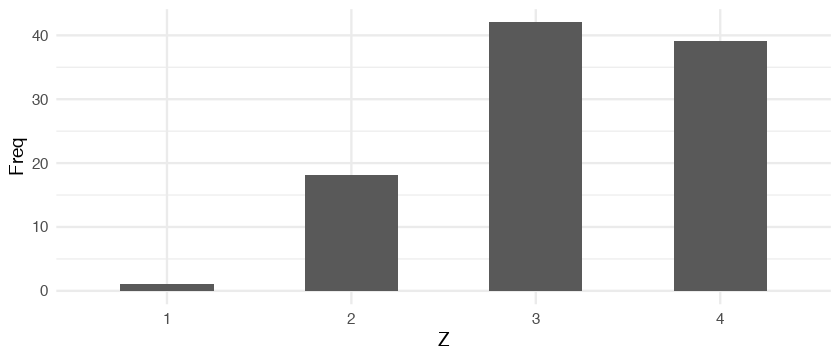

In [15]:
data.frame(table(Z))%>%
    ggplot() +
    geom_col(aes(Z, Freq), width=.5) +
    theme_minimal()

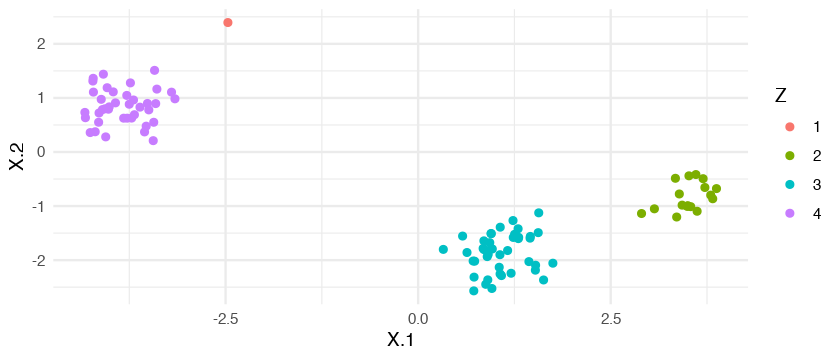

In [16]:
data.frame(X=X, Z=as.factor(Z)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

### Posterior inference using Gibbs sampling

We use *Gibbs sampling* for inference of the class assignments.

Initialization of cluster assignments: all to table 1. Hyperparameter $\alpha$ controls the probability of opening a new table

In [71]:
# initialization of the cluster assignments
K <- 1
zs <- rep(K, n)
alpha <- 5
tables <- n

Define the priors of the model. We set the covariances to be fixed.

In [72]:
mu.prior <- matrix(c(0, 0), ncol = 2)
sigma.prior <- diag(p)
q.prior <- solve(sigma.prior)

Base distribution $\mathcal{G}_0$:

In [73]:
sigma0 <- diag(p)
prec0 <- solve(sigma0)
mu0 <- rep(0, p)

To infer the posterior we would use the Gibbs sampler described above. Here, I am only interested in the most likely assignment, i.e. the map of $Z$.

In [75]:
for (iter in seq(100))
{
  for (i in seq(n))
  {
    # look at data x_i and romove its statistics from the clustering
    zi <- zs[i]
    tables[zi] <- tables[zi] - 1
    if (tables[zi] == 0) {
      K <- K - 1
      zs[zs > zi] <- zs[zs > zi] - 1
      tables <- tables[-zi]
      mu.prior <- mu.prior[-zi, ]
    }
    
    # compute posterior probabilitites P(z_i \mid z_-i, ...)
    no_i <- seq(n)[-i]
    probs <- sapply(seq(K), function(k) {
      crp <- sum(zs[no_i] == k) / (n + alpha - 1)
      lik <- mvtnorm::dmvnorm(X[i, ], mu.prior[k,], sigma.prior)
      crp * lik
    })
    
    # compute probability for opening up a new one
    crp <- alpha / (n + alpha - 1)
    lik <- mvtnorm::dmvnorm(X[i, ], mu0, sigma.prior + sigma0)
    probs <- c(probs, crp * lik)
    probs <- probs / sum(probs)
    
    # sample new z_i according to the conditional posterior above
    z_new <- which.max(probs)
    if (z_new > K) {
      K <- K + 1
      tables <- c(tables, 0)
      mu.prior <- rbind(mu.prior, mvtnorm::rmvnorm(1, mu0, sigma0))
    }
    zs[i] <- z_new        
    tables[z_new] <- tables[z_new] + 1
    
    # compute conditional posterior P(mu \mid ...)
    for(k in seq(K)) {
      Xk <- X[zs == k, ,drop=FALSE]
      lambda <- solve(q.prior + tables[k] * q.prior)
      nominator <- tables[k] * q.prior %*% apply(Xk, 2, mean)
      mu.prior[k, ] <- mvtnorm::rmvnorm(1, lambda %*% nominator, lambda)
    }
  }
}

Let's see if that worked out!

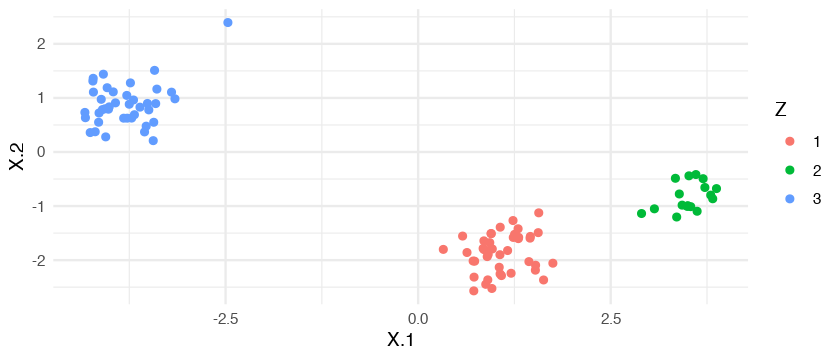

In [76]:
data.frame(X=X, Z=as.factor(zs)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Cool, except for the lone guyu on top the clustering worked nicely.

## The stick-breaking construction

With the CRP with put a prior distribution on the possibly infinite number of class assignments. An alternative approach is to use *stick-breaking* construction. The advantage here is that we could use (a hack for) Stan, thus we don't need to implement the sampler ourselves. Let's give it a try.

### Data generating process

Assuming normally distributed data the hierarchical model for the mixture using stick-breaking is:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0 \\
z_i \mid \mathbf{z}_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim P(\boldsymbol \theta_{z_i})
\end{align*}

where $\text{CRP}$ is a prior on possible infinitely many classes. Specifically the CRP is defined as:

\begin{align*}
P(z_i = k \mid \mathbf{z}_{-i}) = \left\{
                \begin{array}{ll}
                  \frac{N_k}{N - 1 + \alpha}\\
                  \frac{\alpha}{N - 1 + \alpha}\\
                \end{array}
              \right.
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter.

We can do the same think in `greta`

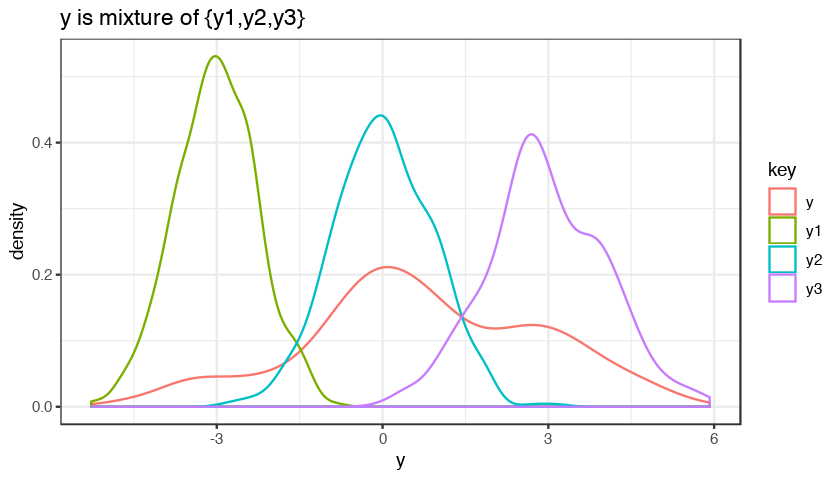

In [145]:
dat %>% 
gather(key, value) %>%
ggplot( aes(value)) + 
geom_density(aes(color = key)) + 
    theme_bw() + xlab("y") + ggtitle("y is mixture of {y1,y2,y3}")

In [ ]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

stan_model <- "
data{
  int<lower=0> C;//num of cludter
  int<lower=0> N;//data num
  real y[N];
}

parameters {
  real mu_cl[C]; //cluster mean
  real <lower=0,upper=1> v[C];
  real<lower=0> sigma_cl[C]; // error scale
  //real<lower=0> alpha; // hyper prior DP(alpha,base)
}

transformed parameters{
  simplex [C] pi;
  pi[1] = v[1];
  // stick-break process based on The BUGS book Chapter 11 (p.294)
  for(j in 2:(C-1)){
      pi[j]= v[j]*(1-v[j-1])*pi[j-1]/v[j-1]; 
  }
  pi[C]=1-sum(pi[1:(C-1)]); // to make a simplex.
}

model {
  real alpha = 1;
  real a=0.001;
  real b=0.001;
  real ps[C];
  sigma_cl ~ inv_gamma(a,b);
  mu_cl ~ normal(0,5);
  //alpha~gamma(6,1);
  v ~ beta(1,alpha);
  
  for(i in 1:N){
    for(c in 1:C){
      ps[c]=log(pi[c])+normal_lpdf(y[i]|mu_cl[c],sigma_cl[c]);
    }
    target += log_sum_exp(ps);
  }

}
"
y <- dat$y
C <- 10  # to ensure large enough
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
# model_object<-stan_model(model_code=stan_model)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

In [146]:
y <- dat$y
C <- 10
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:tidyr’:

    extract



In file included from file2434354ece5e.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp

Warning message:
“There were 479 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [147]:
plot_dat_pi <- data.frame(results$pi) %>% 
    as_data_frame() %>% 
    set_names(sprintf("pi%02d", 1:10)) 

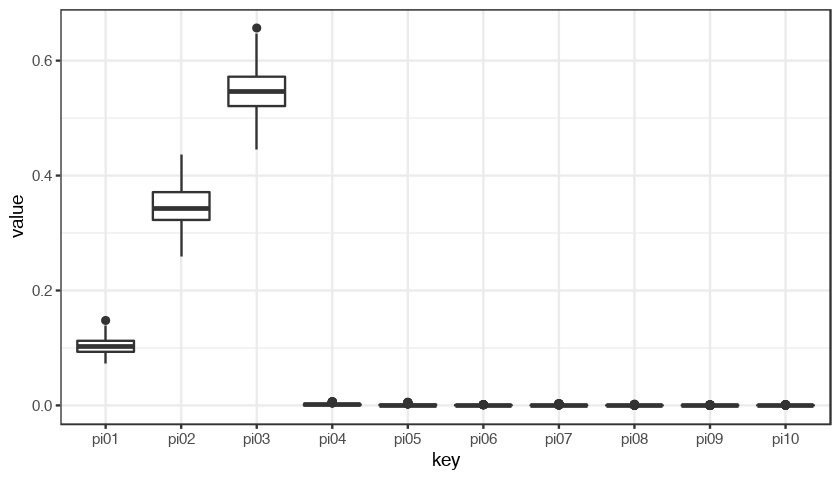

In [148]:
plot_dat_pi %>% 
    gather(key, value) %>%
    ggplot(aes(x = key, y = value)) + 
    geom_boxplot() + 
    theme_bw()


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



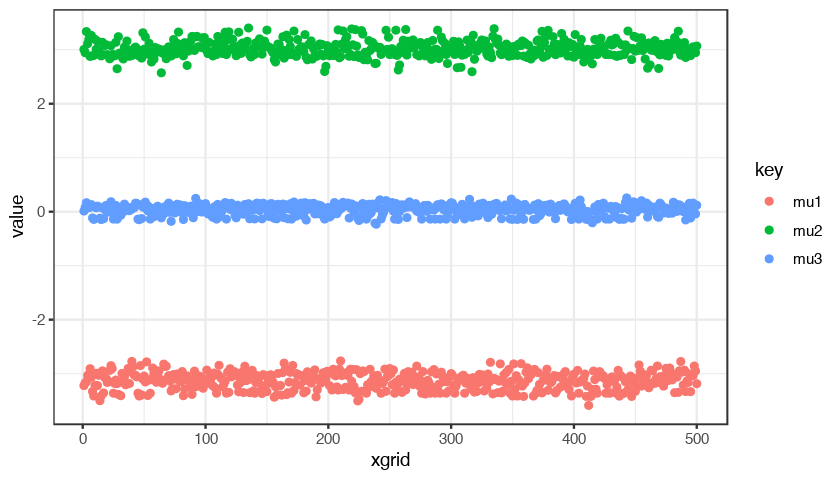

In [149]:
library(gridExtra)
plot_mu_dat <- data.frame(results$mu_cl[, 1:3]) %>% as_data_frame() %>% set_names(sprintf("mu%d", 
    1:3))
plot_mu_dat %<>% mutate(xgrid = (1:length(plot_mu_dat$mu1)))
ggplot(plot_mu_dat %>% gather(key, value, mu1:mu3), aes(x = xgrid, y = value, 
    color = key)) + geom_point() + theme_bw()